In [ ]:
pip install mne

In [ ]:
pip install connectivipy

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [112]:
import mne
import numpy as np
import pandas as pd
import networkx as nx
import connectivipy as cp 
import matplotlib.pyplot as plt

In [113]:
EO = mne.io.read_raw_edf("drive/MyDrive/BioNeuro/S059R01.edf")
eo_data = EO.to_data_frame()
eo_data = eo_data.drop(["time"], axis=1)
freq_eo = EO.info["sfreq"]
ch_eo = EO.ch_names

EC = mne.io.read_raw_edf("drive/MyDrive/BioNeuro/S059R02.edf")
ec_data = EC.to_data_frame()
ec_data = ec_data.drop(["time"], axis=1)
freq_ec = EC.info["sfreq"]
ch_ec = EC.ch_names

Extracting EDF parameters from /content/drive/MyDrive/BioNeuro/S059R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/MyDrive/BioNeuro/S059R02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [114]:
EO.info

<Info | 7 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
>

In [115]:
eo_data.head()

Fc5.   Fc3.   Fc1.   Fcz.  Fc2.  ...  Po8.   O1..   Oz..   O2..   Iz..
0   98.0  107.0  126.0 -101.0  34.0  ... -68.0 -275.0 -334.0 -218.0  271.0
1  145.0  152.0  168.0  -76.0  50.0  ... -63.0 -262.0 -328.0 -210.0  283.0
2   96.0  105.0  121.0  -73.0  59.0  ... -18.0 -219.0 -289.0 -170.0  327.0
3  110.0  116.0  136.0  -50.0  86.0  ...  -8.0 -216.0 -287.0 -162.0  325.0
4  103.0  110.0  129.0  -64.0  71.0  ... -22.0 -231.0 -302.0 -177.0  295.0

[5 rows x 64 columns]

# Basic visualizations

/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


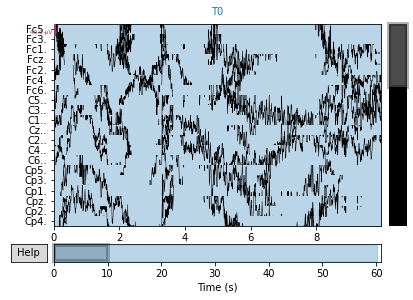

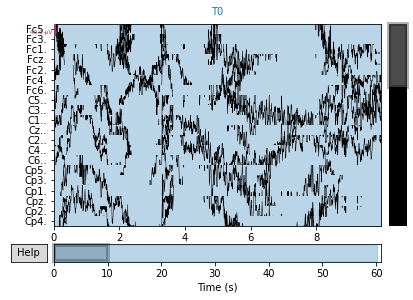

In [116]:
EO.plot()

(-800.0, 800.0)

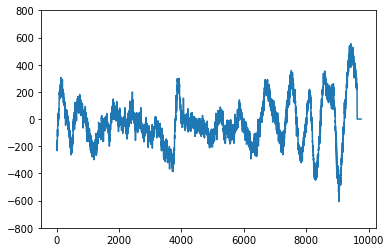

In [117]:
plt.plot(eo_data["O2.."])
plt.ylim(-800,800)

(-800.0, 800.0)

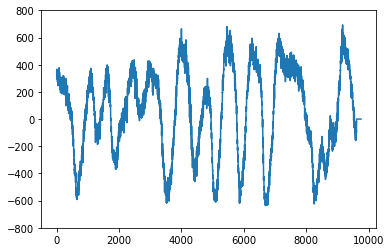

In [118]:
plt.plot(ec_data["O2.."])
plt.ylim(-800,800)

# 1) Connectivity graphs

## 1.1

### Eyes open

In [119]:
print(type(eo_data))
eo = eo_data.values.T
eo.shape

<class 'pandas.core.frame.DataFrame'>


(64, 9760)

In [120]:
obj = cp.mvarmodel.Mvar()
best_order, crit = obj.order_akaike(eo, p_max=15, method='yw')
print(best_order)

/usr/local/lib/python3.6/dist-packages/connectivipy/mvar/fitting.py:267: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  req = np.vstack(rr_b[:, :, x].T for x in range(1, pmax+1))


8


In [121]:
Av, Vf = cp.mvar.fitting.yulewalker(eo, best_order)
Av.shape

/usr/local/lib/python3.6/dist-packages/connectivipy/mvar/fitting.py:267: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  req = np.vstack(rr_b[:, :, x].T for x in range(1, pmax+1))


(8, 64, 64)

In [122]:
pdc = cp.conn.pdc_fun(Av, Vf, freq_eo, 100)
pdc.shape

(100, 64, 64)

In [123]:
ex1 = pdc[12] #the experiment is resting state, so we choose a frequency from the alpha band! (here 13 hz)
vec =  np.linspace(0.122,0.123,11)
for el in vec:
  print(el)
  ope = np.where(ex1<=(el),0,1)
  g1 = nx.DiGraph(ope)
  print(nx.density(g1))
  print()

0.122
0.2058531746031746

0.1221
0.20560515873015872

0.1222
0.20535714285714285

0.12229999999999999
0.20510912698412698

0.1224
0.20362103174603174

0.1225
0.20262896825396826

0.1226
0.20262896825396826

0.1227
0.20163690476190477

0.12279999999999999
0.20064484126984128

0.1229
0.20014880952380953

0.123
0.1996527777777778



In [124]:
#preparing labels
names_ch = [s.replace('.', '') for s in ch_eo]
chiavi_tot = [i for i in range(64)]
label_mapping_tot = {c:0 for c in chiavi_tot}
for c in chiavi_tot:
  label_mapping_tot[c] = names_ch[c]

#label_mapping_tot

In [125]:
#preparing coordinates
cor = pd.read_csv('drive/MyDrive/channel_locations.csv', index_col=0)
cor = cor.sort_values(by=["label"])
cor = cor.reset_index()
cor.head()

index label         x         y
0     26   Af3 -0.134021  0.315733
1     28   Af4  0.134021  0.315733
2     25   Af7 -0.238641  0.328461
3     29   Af8  0.238641  0.328461
4     27   Afz  0.000000  0.304000

In [126]:
names_ch = [s.replace('.', '') for s in ch_eo]
coords_tot = {n:() for n in names_ch}
names_ch.sort()
#print(names_ch == list(coords_tot.keys()))
for k in range(64):
  coords_tot[names_ch[k]] = (cor.iloc[k]["x"], cor.iloc[k]["y"])

#coords_tot

In [127]:
adj1 = np.where(ex1<=(0.1225),0,1) #ADJ MATRIX
g1 = nx.DiGraph(adj1)
g1 = nx.relabel_nodes(g1, label_mapping_tot)
nx.set_node_attributes(g1, coords_tot, 'coord')

In [128]:
#Nodes Colors

central = ["Fc5", "Fc3", "Fc1", "Fcz", "Fc2", "Fc4", "Fc6", "C5", "C3", "C1", "Cz", "C2", "C4", "C6", "Cp5", "Cp3", "Cp1", "Cpz", "Cp2", "Cp4", "Cp6" ]
frontal = ["Fp1", "Fpz", "Fp2", "Af7", "Af3", "Afz", "Af4", "Af8", "F7", "F5", "F3", "F1", "Fz", "F2", "F4", "F6", "F8"]
temporal = ["Ft7", "Ft8", "T7", "T8", "T9", "T10", "Tp7", "Tp8"]
parietal = ["P7", "P5", "P3", "P1", "Pz", "P2", "P4", "P6", "P8", "Po7", "Po3", "Poz", "Po4", "Po8"]
occipital = ["O1", "Oz", "O2", "Iz"]

color_map = []
for node in g1:
    if node in central:
      color_map.append('gold')
    elif node in frontal:
      color_map.append("coral")
    elif node in temporal:
      color_map.append("yellowgreen")
    elif node in parietal: 
      color_map.append("skyblue") 
    elif node in occipital:
      color_map.append("plum")
    else:
      print(node)  

La densità del grafo è 0.2



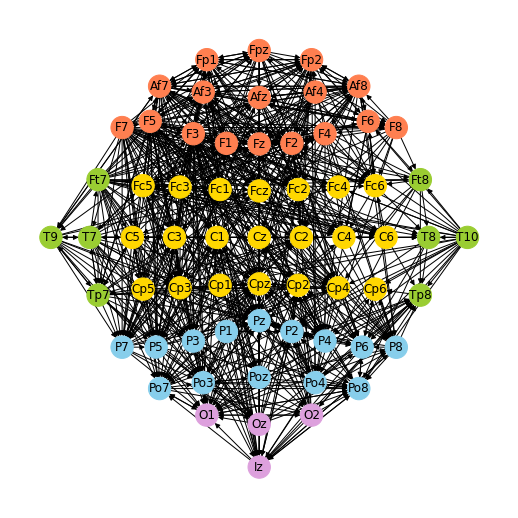

In [129]:
print("La densità del grafo è",round(nx.density(g1),2))
print()
plt.figure(1,figsize=(7,7))
nx.draw(g1, with_labels=True, pos=coords_tot, node_color=color_map, node_size=500)

### Eyes Closed

In [130]:
ec = ec_data.values.T
ec.shape

(64, 9760)

In [131]:
best_order2, crit2 = obj.order_akaike(ec, p_max=15, method='yw')
print(best_order2)

/usr/local/lib/python3.6/dist-packages/connectivipy/mvar/fitting.py:267: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  req = np.vstack(rr_b[:, :, x].T for x in range(1, pmax+1))


7


In [132]:
Av2, Vf2 = cp.mvar.fitting.yulewalker(ec, best_order2)
pdc2 = cp.conn.pdc_fun(Av2, Vf2, freq_ec, 100)

/usr/local/lib/python3.6/dist-packages/connectivipy/mvar/fitting.py:267: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  req = np.vstack(rr_b[:, :, x].T for x in range(1, pmax+1))


In [133]:
ex2 = pdc2[12] #the experiment is resting state, so we choose a frequency from the alpha band! (here 13 hz)
vec =  np.linspace(0.122,0.123,11)
for el in vec:
  print(el)
  clo = np.where(ex2<=(el),0,1)
  g2 = nx.DiGraph(clo)
  print(nx.density(g2))
  print()

0.122
0.20089285714285715

0.1221
0.20064484126984128

0.1222
0.2003968253968254

0.12229999999999999
0.19890873015873015

0.1224
0.19816468253968253

0.1225
0.19791666666666666

0.1226
0.19766865079365079

0.1227
0.19766865079365079

0.12279999999999999
0.1974206349206349

0.1229
0.1966765873015873

0.123
0.19618055555555555



La densità del grafo è 0.2



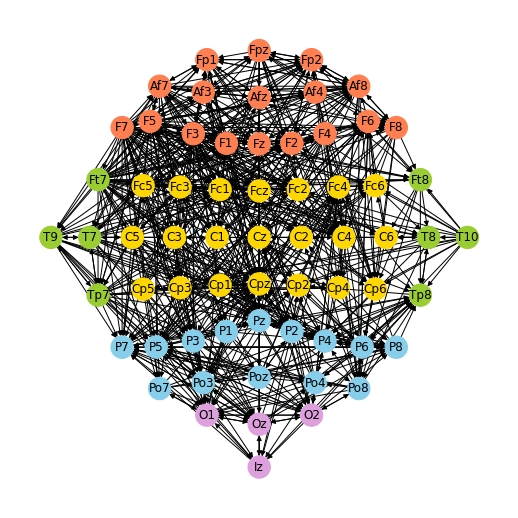

In [134]:
adj2 = np.where(ex2<=(0.1225),0,1) #ADJ MATRIX
g2 = nx.DiGraph(adj2)
g2 = nx.relabel_nodes(g2, label_mapping_tot)
nx.set_node_attributes(g2, coords_tot, 'coord')

print("La densità del grafo è",round(nx.density(g2),2))
print()
plt.figure(1,figsize=(7,7))
nx.draw(g2, with_labels=True, pos=coords_tot, node_color=color_map, node_size=500)

## 1.2

Same graphs but with DFT

In [135]:
# Direct Transfer Function - Eyes open
dtf1 = cp.conn.dtf_fun(Av, Vf, fs=freq_eo, resolution=100) # spectral multivariate autoregressive estimator: partial directed coherence

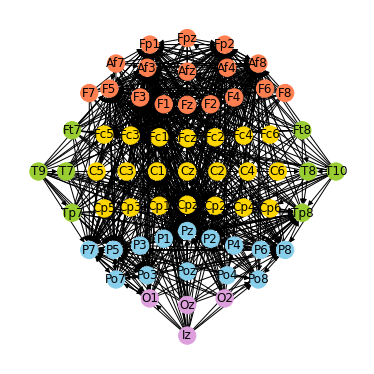

In [136]:
exe1 = dtf1[12]
adjEO = np.where(exe1<=(0.1225),0,1) #ADJ MATRIX
geo = nx.DiGraph(adjEO)
geo = nx.relabel_nodes(geo, label_mapping_tot)
nx.set_node_attributes(geo, coords_tot, 'coord')

plt.figure(1,figsize=(5,5))
nx.draw(geo, with_labels=True, pos=coords_tot, node_color=color_map)

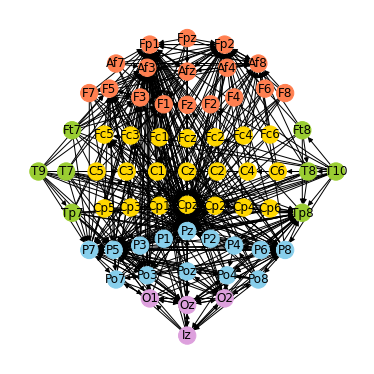

In [137]:
# Direct Transfer Function - Eyes closed
dtf2 = cp.conn.dtf_fun(Av2,Vf2,fs=freq_ec,resolution=100) # spectral multivariate autoregressive estimator: partial directed coherence
exe2 = dtf2[12]
adjEC = np.where(exe2<=(0.1225),0,1) #ADJ MATRIX
gec = nx.DiGraph(adjEC)
gec = nx.relabel_nodes(gec, label_mapping_tot)
nx.set_node_attributes(gec, coords_tot, 'coord')

plt.figure(1,figsize=(5,5))
nx.draw(gec, with_labels=True, pos=coords_tot, node_color=color_map)

## 1.3

In [138]:
#eyes open 
vec =  [0.51,0.212,0.16,0.1225,0.1,0.066]
grafi = []
for el in vec:
  print(el)
  ope = np.where(ex1<=(el),0,1)
  gr = nx.DiGraph(ope)
  gr = nx.relabel_nodes(gr, label_mapping_tot)
  nx.set_node_attributes(gr, coords_tot, 'coord')
  print('Density:',round(nx.density(gr),2))
  grafi.append(gr)

0.51
Density: 0.01
0.212
Density: 0.05
0.16
Density: 0.1
0.1225
Density: 0.2
0.1
Density: 0.3
0.066
Density: 0.5


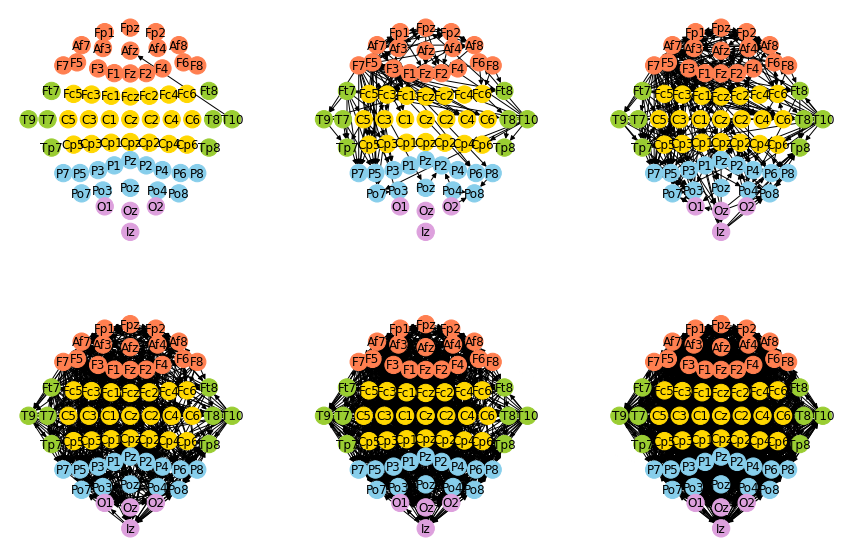

In [139]:
rows = 2
columns = 3
fig=plt.figure(figsize=(15,10))
for i in range(1, 7):
    fig.add_subplot(rows, columns, i)
    nx.draw(grafi[i-1], with_labels=True, pos=coords_tot, node_color=color_map)

In [140]:
#eyes closed 
vec =  [0.51,0.212,0.16,0.1225,0.1,0.066]
grafi2 = []
for el in vec:
  print(el)
  ope2 = np.where(ex2<=(el),0,1)
  gr = nx.DiGraph(ope2)
  gr = nx.relabel_nodes(gr, label_mapping_tot)
  nx.set_node_attributes(gr, coords_tot, 'coord')
  print('Density:',round(nx.density(gr),2))
  grafi2.append(gr)

0.51
Density: 0.01
0.212
Density: 0.05
0.16
Density: 0.1
0.1225
Density: 0.2
0.1
Density: 0.3
0.066
Density: 0.5


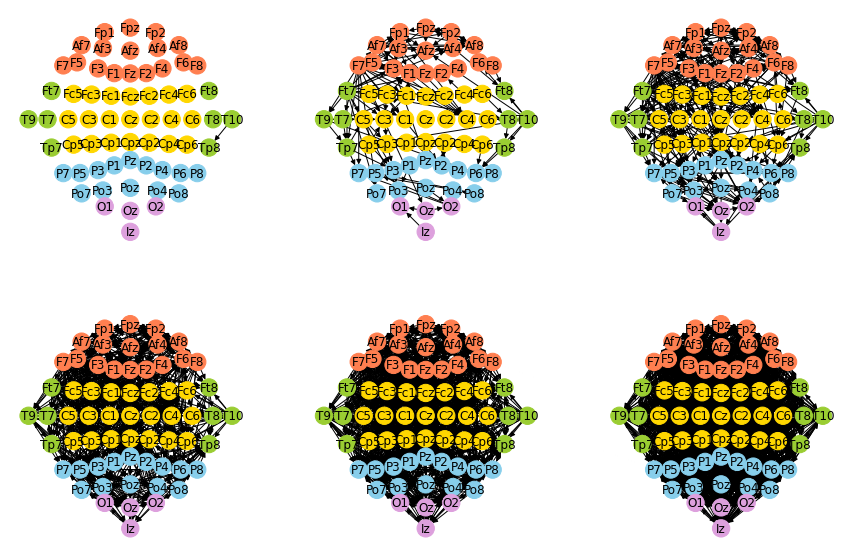

In [141]:
rows = 2
columns = 3
fig=plt.figure(figsize=(15,10))
for i in range(1, 7):
    fig.add_subplot(rows, columns, i)
    nx.draw(grafi2[i-1], with_labels=True, pos=coords_tot, node_color=color_map)

## 1.4 & 1.5


In [142]:
subset = ["Fp1", "Fp2", "F7", "F3", "Fz", "F4", "F8", "T7", "C3", "Cz", "C4", "T8", "P7", "P3", "Pz", "P4", "P8", "O1", "O2"]

In [143]:
names_ch = [s.replace('.', '') for s in ch_eo]
eo_data.columns = names_ch
ec_data.columns = names_ch

In [144]:
sub_eo = eo_data[subset].values.T
print(sub_eo.shape)
sub_ec = ec_data[subset].values.T
print(sub_ec.shape)

(19, 9760)
(19, 9760)


In [145]:
o_sub1, c_sub1 = obj.order_akaike(sub_eo, p_max=15, method='yw')
print(o_sub1)
o_sub2, c_sub2 = obj.order_akaike(sub_ec, p_max=20, method='yw')
print(o_sub2)

/usr/local/lib/python3.6/dist-packages/connectivipy/mvar/fitting.py:267: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  req = np.vstack(rr_b[:, :, x].T for x in range(1, pmax+1))


14
19


In [146]:
sub_EO = cp.data.Data(sub_eo, fs=freq_eo, chan_names=subset)
sub_EC = cp.data.Data(sub_ec, fs=freq_ec, chan_names=subset)

/usr/local/lib/python3.6/dist-packages/connectivipy/data.py:340: Warning: Number of channels > 10.
                          Consider picking only some channels.
  Consider picking only some channels.""", Warning)


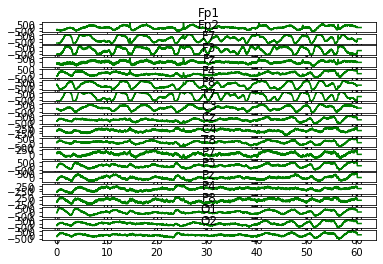

In [147]:
sub_EO.plot_data()
#plt.figure((20,20))

In [148]:
# fit mvar using Yule-Walker algorithm 
sub_EO.fit_mvar(o_sub1, 'yw')
sub_EC.fit_mvar(o_sub2, 'yw')

# you can capture fitted parameters and residual matrix
A_sub1, V_sub1 = sub_EO.mvar_coefficients
A_sub2, V_sub2 = sub_EC.mvar_coefficients

/usr/local/lib/python3.6/dist-packages/connectivipy/mvar/fitting.py:267: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  req = np.vstack(rr_b[:, :, x].T for x in range(1, pmax+1))


In [149]:
# now we investigate connectivity 
pdc_sub1 = cp.conn.pdc_fun(A_sub1, V_sub1, freq_eo, 100)
pdc_sub2 = cp.conn.pdc_fun(A_sub2, V_sub2, freq_ec, 100)

#and compute pvalues
p1_values = sub_EO.conn(method="pdc")
pdc1_sign = sub_EO.significance(Nrep=100, alpha=0.05)

p2_values = sub_EC.conn(method="pdc")
pdc2_sign = sub_EC.significance(Nrep=100, alpha=0.05)

. . 

/usr/local/lib/python3.6/dist-packages/connectivipy/mvar/fitting.py:267: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  req = np.vstack(rr_b[:, :, x].T for x in range(1, pmax+1))


. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . |
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . |


In [150]:
p_sub1 = pdc_sub1[12]
p_sub2 = pdc_sub2[12]

In [151]:
#getting coordinates of nodes
#df = pd.read_csv('drive/MyDrive/channel_locations.csv', index_col=0)
df = cor.loc[cor['label'].isin(subset)]
df = df.sort_values(by=["label"])
df = df.reset_index()
df.head()

level_0  index label         x             y
0        7      9    C3 -0.203000  1.243530e-17
1        8     13    C4  0.203000  1.243530e-17
2       18     11    Cz  0.000000  0.000000e+00
3       21     32    F3 -0.157734  2.252668e-01
4       22     36    F4  0.157734  2.252668e-01

In [152]:
chiavi = [i for i in range(19)]
label_mapping = {c:0 for c in chiavi}
for c in chiavi:
  label_mapping[c] = subset[c]

#label_mapping

In [153]:
#new color map
colors_sub = []
for node in subset:
    if node in central:
      colors_sub.append('gold')
    elif node in frontal:
      colors_sub.append("coral")
    elif node in temporal:
      colors_sub.append("yellowgreen")
    elif node in parietal: 
      colors_sub.append("skyblue") 
    elif node in occipital:
      colors_sub.append("plum")
    else:
      print(node)  

In [154]:
coords = {n:() for n in subset}
subset.sort()
#print(subset == list(coords.keys()))
for k in range(19):
  coords[subset[k]] = (df.iloc[k]["x"], df.iloc[k]["y"])

#coords

La densità del grafo è 0.1



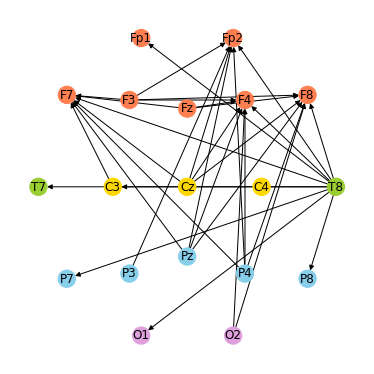

In [155]:
#Eyes Open
adj3 = np.where(pdc1_sign <= (0.05), 1,0)
g3 = nx.DiGraph(adj3)
g3 = nx.relabel_nodes(g3, label_mapping)
nx.set_node_attributes(g3, coords, 'coord')
print("La densità del grafo è",round(nx.density(g3),2))
print()
plt.figure(1,figsize=(5,5))
nx.draw(g3, with_labels = True, pos=coords, node_color=colors_sub)

La densità del grafo è 0.13



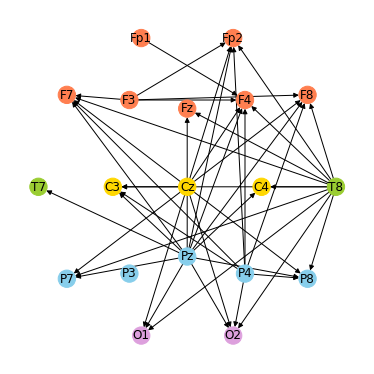

In [156]:
#Eyes Closed
adj4 = np.where(pdc2_sign <= (0.05), 1,0)
g4 = nx.DiGraph(adj4)
g4 = nx.relabel_nodes(g4, label_mapping)
nx.set_node_attributes(g4, coords, 'coord')
print("La densità del grafo è",round(nx.density(g4),2))
print()

plt.figure(1,figsize=(5,5))
nx.draw(g4, with_labels=True, pos=coords, node_color=colors_sub)

## 1.6

La densità del grafo è 0.2



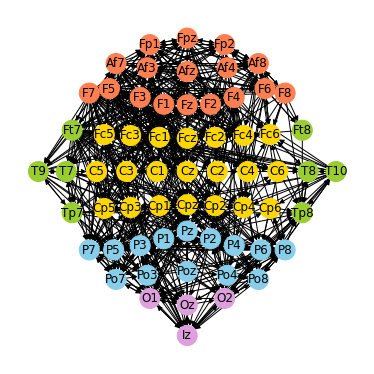

In [157]:
#eyes open
ex16 = pdc[29]  #30hz from beta band 
adj16 = np.where(ex16<=(0.1225),0,1) #ADJ MATRIX
g16 = nx.DiGraph(adj16)
g16 = nx.relabel_nodes(g16, label_mapping_tot)
nx.set_node_attributes(g16, coords_tot, 'coord')
print("La densità del grafo è",round(nx.density(g16),2))
print()

plt.figure(1,figsize=(5,5))
nx.draw(g16, with_labels=True, pos=coords_tot, node_color=color_map, node_size=400)

La densità del grafo è 0.2



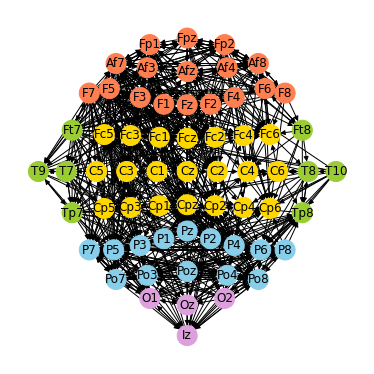

In [158]:
#eyes open
ex16_2 = pdc2[29]  #30hz from beta band 
adj16_2 = np.where(ex16_2<=(0.1245),0,1) #ADJ MATRIX
g16_2 = nx.DiGraph(adj16_2)
g16_2 = nx.relabel_nodes(g16_2, label_mapping_tot)
nx.set_node_attributes(g16_2, coords_tot, 'coord')
print("La densità del grafo è",round(nx.density(g16_2),2))
print()

plt.figure(1,figsize=(5,5))
nx.draw(g16_2, with_labels=True, pos=coords_tot, node_color=color_map, node_size=400)

# 2) Network analysis

## 2.1

### Eyes Open

In [159]:
print("Average clustering coefficient:", round(nx.average_clustering(g1),3))
print()
print("Average path length:", round(nx.average_shortest_path_length(g1),3))

Average clustering coefficient: 0.289

Average path length: 2.269


In [160]:
eo_top = sorted(g1.degree, key=lambda x: x[1], reverse=True)[:10]
for i in range(len(eo_top)):
  print(i+1,'- Node',eo_top[i][0],'has degree',eo_top[i][1])

1 - Node F3 has degree 57
2 - Node F5 has degree 50
3 - Node Af3 has degree 40
4 - Node F7 has degree 40
5 - Node Pz has degree 39
6 - Node Af7 has degree 38
7 - Node Af8 has degree 36
8 - Node Fp1 has degree 35
9 - Node Fp2 has degree 35
10 - Node F2 has degree 34


In [161]:
in1 = sorted(g1.in_degree, key=lambda x: x[1], reverse=True)[:10]
for i in range(len(in1)):
  print(i+1,'- Node',in1[i][0],'has IN-degree',in1[i][1])

1 - Node Cpz has IN-degree 31
2 - Node Pz has IN-degree 31
3 - Node F2 has IN-degree 23
4 - Node Fz has IN-degree 22
5 - Node O1 has IN-degree 21
6 - Node P7 has IN-degree 20
7 - Node P5 has IN-degree 20
8 - Node Po3 has IN-degree 20
9 - Node Cp4 has IN-degree 19
10 - Node P2 has IN-degree 19


In [162]:
out1 = sorted(g1.out_degree, key=lambda x: x[1], reverse=True)[:10]
for i in range(len(out1)):
  print(i+1,'- Node',out1[i][0],'has OUT-degree',out1[i][1])

1 - Node F3 has OUT-degree 43
2 - Node F5 has OUT-degree 41
3 - Node F7 has OUT-degree 39
4 - Node Ft7 has OUT-degree 30
5 - Node Af7 has OUT-degree 29
6 - Node T10 has OUT-degree 25
7 - Node Af3 has OUT-degree 24
8 - Node Fpz has OUT-degree 22
9 - Node T7 has OUT-degree 22
10 - Node Fp1 has OUT-degree 20


### Eyes closed

In [163]:
# Global
print("Average clustering coefficient:", round(nx.average_clustering(g2),3))
print("Average path length:", round(nx.average_shortest_path_length(g2),3))

Average clustering coefficient: 0.297
Average path length: 2.229


In [164]:
ec_top = sorted(g2.degree, key=lambda x: x[1], reverse=True)[:10]
for i in range(len(ec_top)):
  print(i+1,'- Node',ec_top[i][0],'has degree',ec_top[i][1])

1 - Node F3 has degree 48
2 - Node F5 has degree 47
3 - Node F7 has degree 46
4 - Node Ft7 has degree 45
5 - Node Pz has degree 39
6 - Node Af8 has degree 35
7 - Node Cpz has degree 34
8 - Node Af7 has degree 34
9 - Node F2 has degree 34
10 - Node Fc1 has degree 33


In [165]:
in2 = sorted(g2.in_degree, key=lambda x: x[1], reverse=True)[:10]
for i in range(len(in2)):
  print(i+1,'- Node',in2[i][0],'has IN-degree',in2[i][1])

1 - Node Cpz has IN-degree 31
2 - Node Pz has IN-degree 30
3 - Node F2 has IN-degree 24
4 - Node P7 has IN-degree 23
5 - Node P5 has IN-degree 22
6 - Node C4 has IN-degree 20
7 - Node Fz has IN-degree 19
8 - Node P4 has IN-degree 19
9 - Node Fc4 has IN-degree 18
10 - Node Fp2 has IN-degree 18


In [166]:
out2 = sorted(g2.out_degree, key=lambda x: x[1], reverse=True)[:10]
for i in range(len(out2)):
  print(i+1,'- Node',out2[i][0],'has OUT-degree',out2[i][1])

1 - Node F7 has OUT-degree 45
2 - Node Ft7 has OUT-degree 43
3 - Node F3 has OUT-degree 38
4 - Node F5 has OUT-degree 37
5 - Node Af7 has OUT-degree 27
6 - Node T7 has OUT-degree 21
7 - Node Fpz has OUT-degree 19
8 - Node T10 has OUT-degree 19
9 - Node Tp7 has OUT-degree 19
10 - Node C5 has OUT-degree 18


## 2.2

In [167]:
#data we need from our graph
C1 = nx.average_clustering(g1)
L1 = nx.average_shortest_path_length(g1)

In [168]:
#Let's create an equivalent randomic graph
rnd_graph = nx.erdos_renyi_graph(n=64, p=0.20, seed=13, directed=True)
#it has the same number of nodes as ours and almost identical density
print("random graph density:", nx.density(rnd_graph))

random graph density: 0.19940476190476192


In [169]:
#same data from the random graph
Cr = nx.average_clustering(rnd_graph)
Lr = nx.average_shortest_path_length(rnd_graph)

In [170]:
# EYES OPEN
#formula of small world index = (C/Cr)/(L/Lr)
sm1 = (C1/Cr)/(L1/Lr)
print(sm1) 
# it's greater than 1 so the network it'small world

1.2032729392661843


In [171]:
#data we need from our graph
C2 = nx.average_clustering(g2)
L2 = nx.average_shortest_path_length(g2)

In [172]:
# EYES OPEN
#formula of small world index = (C/Cr)/(L/Lr)
sm2 = (C2/Cr)/(L2/Lr)
print(sm2) 
# it's greater than 1 so the network it'small world

1.258084112892972


## 2.3

In [173]:
#DTF graph eyes open
print("La densità del grafo è",round(nx.density(geo),2))
print("Average clustering coefficient:", round(nx.average_clustering(geo),3))
print("Average path length:", round(nx.average_shortest_path_length(geo),3))

La densità del grafo è 0.19
Average clustering coefficient: 0.547
Average path length: 0.876


In [174]:
#DTF graph eyes closed
print("La densità del grafo è",round(nx.density(gec),2))
print("Average clustering coefficient:", round(nx.average_clustering(gec),3))
print("Average path length:", round(nx.average_shortest_path_length(gec),3))

La densità del grafo è 0.14
Average clustering coefficient: 0.51
Average path length: 1.051


## 2.4

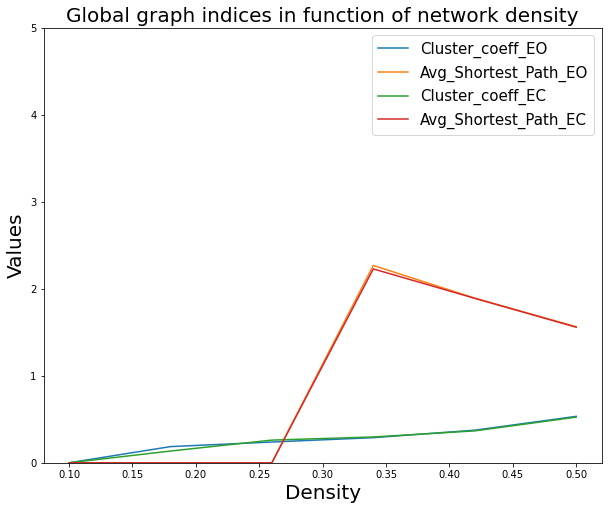

In [175]:
gra ={'Cluster_coeff_EO':[],'Avg_Shortest_Path_EO':[],'Cluster_coeff_EC':[],"Avg_Shortest_Path_EC":[]}

for g_1 in grafi:
  gra['Cluster_coeff_EO'].append(round(nx.average_clustering(g_1),3))
  if nx.is_weakly_connected(g_1):
      gra["Avg_Shortest_Path_EO"].append(round(nx.average_shortest_path_length(g_1),3))
  else:
    gra["Avg_Shortest_Path_EO"].append(0.0)
  
for g_2 in grafi2:
  gra['Cluster_coeff_EC'].append(round(nx.average_clustering(g_2),3))
  if nx.is_weakly_connected(g_2):
      gra["Avg_Shortest_Path_EC"].append(round(nx.average_shortest_path_length(g_2),3))
  else:
    gra["Avg_Shortest_Path_EC"].append(0.0)


plt.figure(figsize=(10,8))
for key in gra:
  plt.plot(np.linspace(0.1,0.5,6),gra[key])
plt.title('Global graph indices in function of network density',fontsize=20)
plt.legend(gra.keys(), fontsize=15)
plt.ylabel('Values',fontsize=20)
plt.xlabel('Density',fontsize=20)
plt.ylim(0,5)
plt.show()

## 2.5 

### Eyes Open

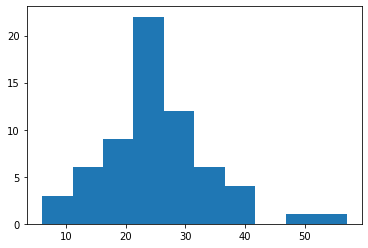

In [176]:
#out of curiosity let's check the distribution of nodes' degrees in the open eyes condition
degrees = [g1.degree(n) for n in g1.nodes()]
plt.hist(degrees)
plt.show()

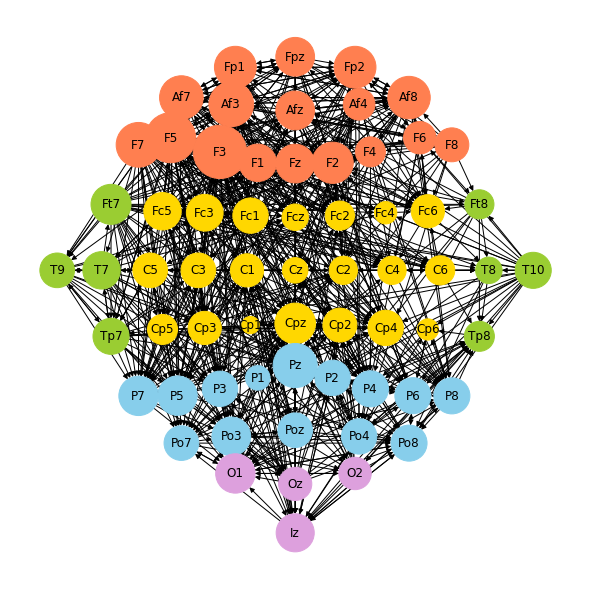

In [177]:
d = dict(g1.degree) 

plt.figure(1,figsize=(8,8))
nx.draw(g1, nodelist=list(d.keys()), node_size=[v * 50 for v in d.values()], with_labels=True, pos=coords_tot, node_color=color_map)

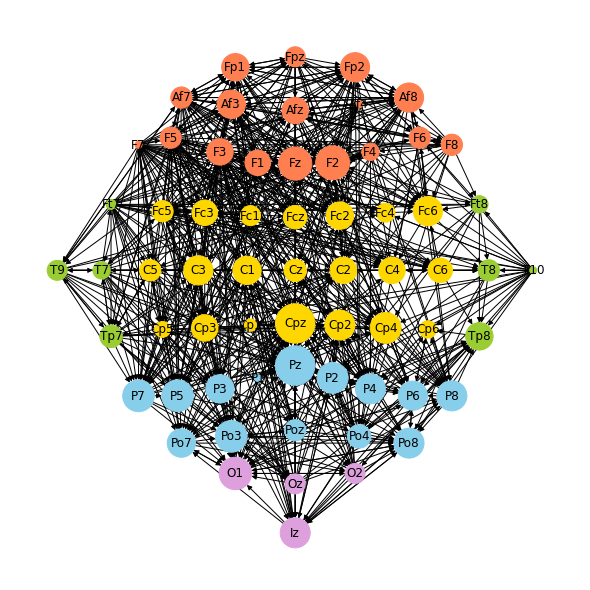

In [178]:
d_2 = dict(g1.in_degree)

plt.figure(1,figsize=(8,8))
nx.draw(g1, nodelist=list(d_2.keys()), node_size=[v * 50 for v in d_2.values()], with_labels=True, pos=coords_tot, node_color=color_map)

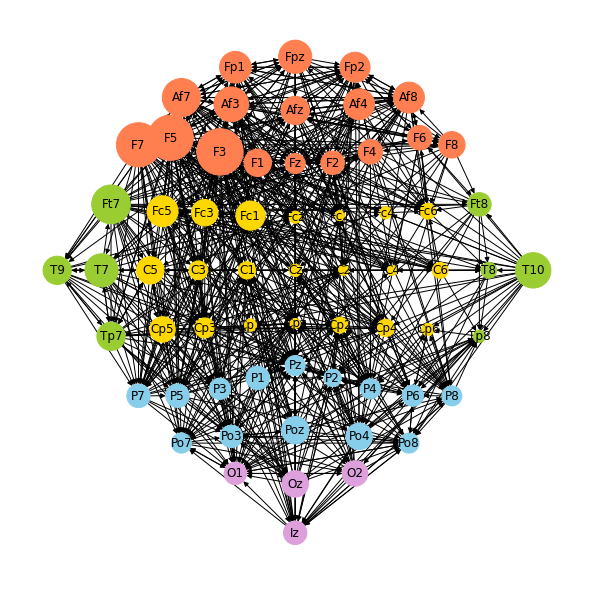

In [179]:
d_3 = dict(g1.out_degree)

plt.figure(1,figsize=(8,8))
nx.draw(g1, nodelist=list(d_3.keys()), node_size=[v * 50 for v in d_3.values()], with_labels=True, pos=coords_tot, node_color=color_map)

### Eyes Closed

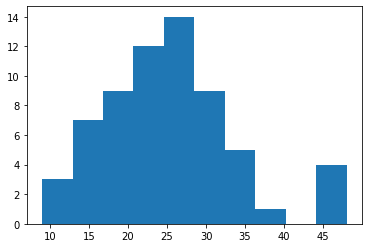

In [180]:
#for curiosity let's check the distribution of nodes' degrees in the open eyes condition
degrees2 = [g2.degree(n) for n in g2.nodes()]
plt.hist(degrees2)
plt.show()

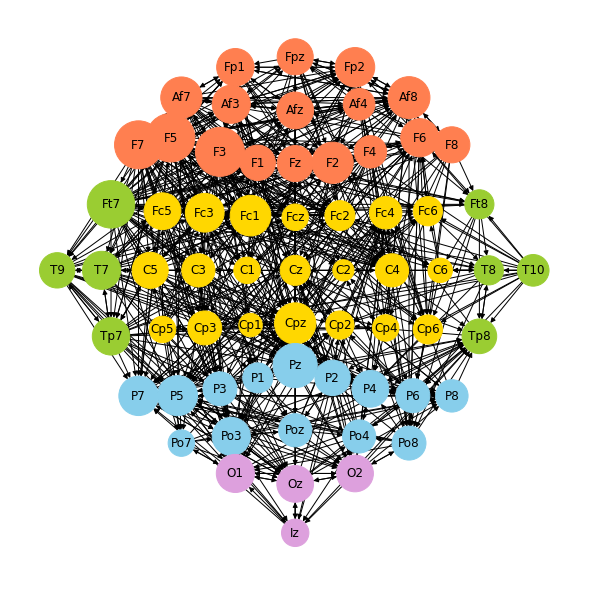

In [181]:
d2 = dict(g2.degree) 

plt.figure(1,figsize=(8,8))
nx.draw(g2, nodelist=list(d2.keys()), node_size=[v * 50 for v in d2.values()], with_labels=True, pos=coords_tot, node_color=color_map)

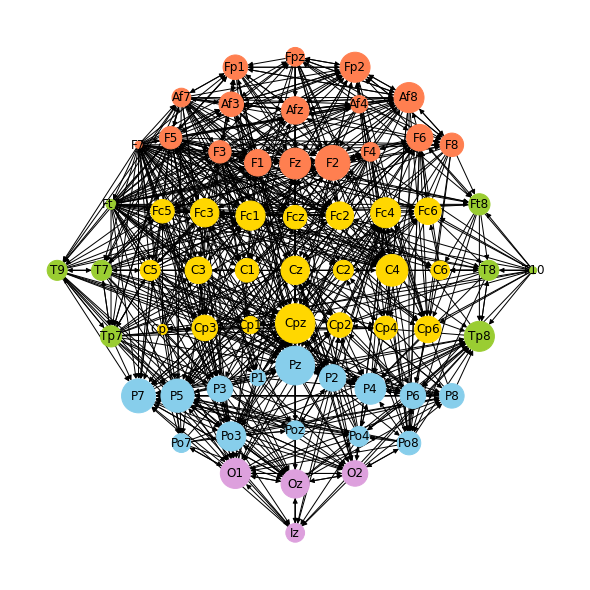

In [182]:
d_22 = dict(g2.in_degree)

plt.figure(1,figsize=(8,8))
nx.draw(g2, nodelist=list(d_22.keys()), node_size=[v * 50 for v in d_22.values()], with_labels=True, pos=coords_tot, node_color=color_map)

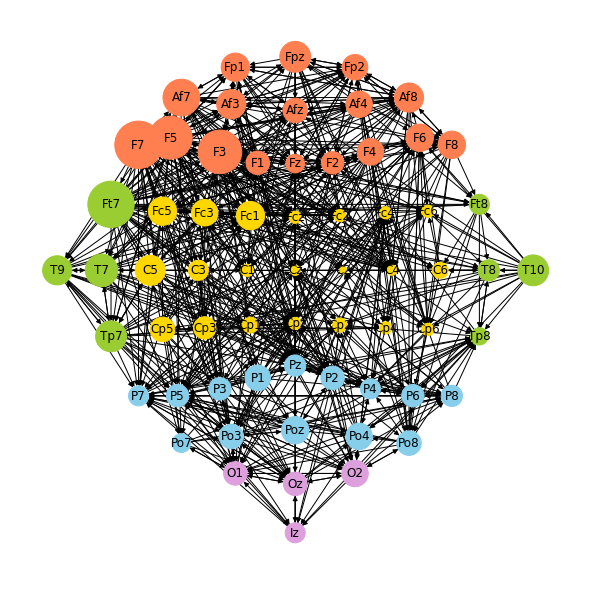

In [183]:
d_32 = dict(g2.out_degree)

plt.figure(1,figsize=(8,8))
nx.draw(g2, nodelist=list(d_32.keys()), node_size=[v * 50 for v in d_32.values()], with_labels=True, pos=coords_tot, node_color=color_map)

## 2.6

In [184]:
#eyes open 
print("Average clustering coefficient:", round(nx.average_clustering(g16),3))
print()
print("Average path length:", round(nx.average_shortest_path_length(g16),3))
print()
eo_top = sorted(g16.degree, key=lambda x: x[1], reverse=True)[:10]
for i in range(len(eo_top)):
  print(i+1,'- Node',eo_top[i][0],'has degree',eo_top[i][1])
print()
in1 = sorted(g16.in_degree, key=lambda x: x[1], reverse=True)[:10]
for i in range(len(in1)):
  print(i+1,'- Node',in1[i][0],'has IN-degree',in1[i][1])
print()
out1 = sorted(g16.out_degree, key=lambda x: x[1], reverse=True)[:10]
for i in range(len(out1)):
  print(i+1,'- Node',out1[i][0],'has OUT-degree',out1[i][1])

Average clustering coefficient: 0.306

Average path length: 2.259

1 - Node F3 has degree 47
2 - Node F7 has degree 43
3 - Node F5 has degree 43
4 - Node Pz has degree 40
5 - Node Fp1 has degree 36
6 - Node Ft7 has degree 36
7 - Node Cpz has degree 35
8 - Node Af3 has degree 35
9 - Node P7 has degree 34
10 - Node P3 has degree 34

1 - Node Cpz has IN-degree 32
2 - Node Pz has IN-degree 31
3 - Node P7 has IN-degree 23
4 - Node C1 has IN-degree 20
5 - Node Cp3 has IN-degree 20
6 - Node Cp2 has IN-degree 20
7 - Node Fz has IN-degree 20
8 - Node P5 has IN-degree 19
9 - Node Afz has IN-degree 18
10 - Node F2 has IN-degree 18

1 - Node F7 has OUT-degree 42
2 - Node F3 has OUT-degree 35
3 - Node F5 has OUT-degree 33
4 - Node Ft7 has OUT-degree 32
5 - Node Af7 has OUT-degree 27
6 - Node Fp1 has OUT-degree 20
7 - Node Fpz has OUT-degree 20
8 - Node T10 has OUT-degree 20
9 - Node Af3 has OUT-degree 18
10 - Node F1 has OUT-degree 17


In [185]:
#eyes open 
print("Average clustering coefficient:", round(nx.average_clustering(g16_2),3))
print()
print("Average path length:", round(nx.average_shortest_path_length(g16_2),3))
print()
eo_top = sorted(g16_2.degree, key=lambda x: x[1], reverse=True)[:10]
for i in range(len(eo_top)):
  print(i+1,'- Node',eo_top[i][0],'has degree',eo_top[i][1])
print()
in1 = sorted(g16_2.in_degree, key=lambda x: x[1], reverse=True)[:10]
for i in range(len(in1)):
  print(i+1,'- Node',in1[i][0],'has IN-degree',in1[i][1])
print()
out1 = sorted(g16_2.out_degree, key=lambda x: x[1], reverse=True)[:10]
for i in range(len(out1)):
  print(i+1,'- Node',out1[i][0],'has OUT-degree',out1[i][1])

Average clustering coefficient: 0.34

Average path length: 2.056

1 - Node F3 has degree 46
2 - Node Af7 has degree 45
3 - Node F7 has degree 43
4 - Node F5 has degree 43
5 - Node Pz has degree 42
6 - Node P7 has degree 41
7 - Node P5 has degree 40
8 - Node P4 has degree 39
9 - Node Af3 has degree 38
10 - Node Fp1 has degree 36

1 - Node Cpz has IN-degree 29
2 - Node Pz has IN-degree 27
3 - Node Cp2 has IN-degree 26
4 - Node P7 has IN-degree 26
5 - Node P5 has IN-degree 25
6 - Node Po8 has IN-degree 22
7 - Node Fc5 has IN-degree 20
8 - Node Fc3 has IN-degree 20
9 - Node F2 has IN-degree 20
10 - Node P4 has IN-degree 20

1 - Node F7 has OUT-degree 41
2 - Node F3 has OUT-degree 34
3 - Node F5 has OUT-degree 32
4 - Node Af7 has OUT-degree 31
5 - Node Ft7 has OUT-degree 30
6 - Node Af3 has OUT-degree 23
7 - Node Fp1 has OUT-degree 20
8 - Node T7 has OUT-degree 19
9 - Node P2 has OUT-degree 19
10 - Node P4 has OUT-degree 19


## 2.7

In [186]:
wdj1 = ex1.copy()
wdj2 = ex2.copy()

#metto il 0 dove adj ha 0, lascio il peso altrove
wdj1 = np.where(adj1==0, 0, wdj1)
wdj2 = np.where(adj2==0, 0, wdj2)

La densità del grafo è 0.2



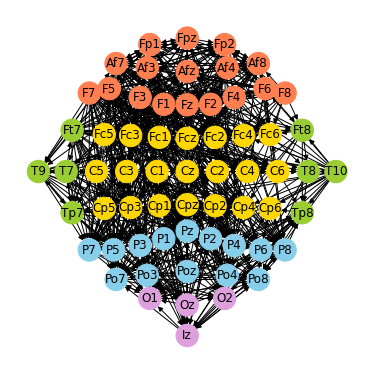

In [187]:
#Eyes open
gw1 = nx.from_numpy_matrix(wdj1, create_using=nx.DiGraph)
gw1 = nx.relabel_nodes(gw1, label_mapping_tot)
nx.set_node_attributes(gw1, coords_tot, 'coord')
print("La densità del grafo è",round(nx.density(gw1),2))
print()

plt.figure(1,figsize=(5,5))
nx.draw(gw1, with_labels=True, pos=coords_tot, node_color=color_map, node_size=500)

In [188]:
print("Average clustering coefficient:", round(nx.average_clustering(gw1, weight="weight"),3))
print()
print("Average path length:", round(nx.average_shortest_path_length(gw1, weight="weight"),3))
print()
eo_top = sorted(gw1.degree(weight="weight"), key=lambda x: x[1], reverse=True)[:10]
for i in range(len(eo_top)):
  print(i+1,'- Node',eo_top[i][0],'has degree',round(eo_top[i][1],2))
print()
in1 = sorted(gw1.in_degree(weight="weight"), key=lambda x: x[1], reverse=True)[:10]
for i in range(len(in1)):
  print(i+1,'- Node',in1[i][0],'has IN-degree',round(in1[i][1],2))
print()
out1 = sorted(gw1.out_degree(weight="weight"), key=lambda x: x[1], reverse=True)[:10]
for i in range(len(out1)):
  print(i+1,'- Node',out1[i][0],'has OUT-degree',round(out1[i][1],2))

Average clustering coefficient: 0.052

Average path length: 0.338

1 - Node F3 has degree 12.13
2 - Node F5 has degree 11.35
3 - Node F7 has degree 10.81
4 - Node Af7 has degree 8.57
5 - Node Ft7 has degree 7.9
6 - Node T10 has degree 7.54
7 - Node Af3 has degree 7.42
8 - Node Fp1 has degree 6.98
9 - Node Af8 has degree 6.84
10 - Node Fp2 has degree 6.83

1 - Node Pz has IN-degree 4.64
2 - Node Cpz has IN-degree 4.63
3 - Node F2 has IN-degree 4.18
4 - Node Fz has IN-degree 3.91
5 - Node P7 has IN-degree 3.85
6 - Node P5 has IN-degree 3.79
7 - Node O1 has IN-degree 3.66
8 - Node Po3 has IN-degree 3.57
9 - Node Af8 has IN-degree 3.52
10 - Node P2 has IN-degree 3.51

1 - Node F7 has OUT-degree 9.84
2 - Node F3 has OUT-degree 9.19
3 - Node F5 has OUT-degree 8.95
4 - Node Ft7 has OUT-degree 6.81
5 - Node T10 has OUT-degree 6.58
6 - Node Af7 has OUT-degree 6.31
7 - Node Fpz has OUT-degree 4.57
8 - Node T7 has OUT-degree 4.51
9 - Node Af3 has OUT-degree 3.98
10 - Node Af4 has OUT-degree 3.9


La densità del grafo è 0.2



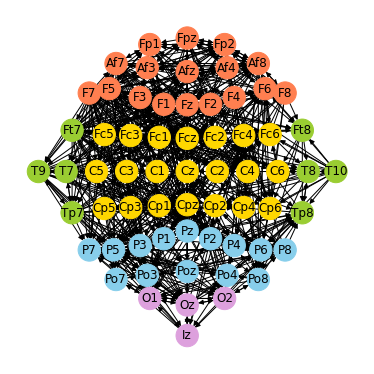

In [189]:
#Eyes closed
gw2 = nx.from_numpy_matrix(wdj2, create_using=nx.DiGraph)
gw2 = nx.relabel_nodes(gw2, label_mapping_tot)
nx.set_node_attributes(gw2, coords_tot, 'coord')
print("La densità del grafo è",round(nx.density(gw2),2))
print()

plt.figure(1,figsize=(5,5))
nx.draw(gw2, with_labels=True, pos=coords_tot, node_color=color_map, node_size=500)

In [190]:
print("Average clustering coefficient:", round(nx.average_clustering(gw2, weight="weight"),3))
print()
print("Average path length:", round(nx.average_shortest_path_length(gw2, weight="weight"),3))
print()
eo_top = sorted(gw2.degree(weight="weight"), key=lambda x: x[1], reverse=True)[:10]
for i in range(len(eo_top)):
  print(i+1,'- Node',eo_top[i][0],'has degree', round(eo_top[i][1],2))
print()
in1 = sorted(gw2.in_degree(weight="weight"), key=lambda x: x[1], reverse=True)[:10]
for i in range(len(in1)):
  print(i+1,'- Node',in1[i][0],'has IN-degree',round(in1[i][1],2))
print()
out1 = sorted(gw2.out_degree(weight="weight"), key=lambda x: x[1], reverse=True)[:10]
for i in range(len(out1)):
  print(i+1,'- Node',out1[i][0],'has OUT-degree', round(out1[i][1],2))

Average clustering coefficient: 0.055

Average path length: 0.34

1 - Node F7 has degree 11.8
2 - Node Ft7 has degree 10.44
3 - Node F5 has degree 9.75
4 - Node F3 has degree 9.7
5 - Node Af7 has degree 7.93
6 - Node Af8 has degree 6.71
7 - Node Fp2 has degree 6.43
8 - Node T7 has degree 6.38
9 - Node Fp1 has degree 6.38
10 - Node Fc1 has degree 6.34

1 - Node Cpz has IN-degree 4.68
2 - Node Pz has IN-degree 4.54
3 - Node F2 has IN-degree 4.1
4 - Node P7 has IN-degree 4.04
5 - Node P5 has IN-degree 3.94
6 - Node C4 has IN-degree 3.89
7 - Node Af8 has IN-degree 3.7
8 - Node Fp2 has IN-degree 3.67
9 - Node Fz has IN-degree 3.43
10 - Node Tp8 has IN-degree 3.34

1 - Node F7 has OUT-degree 10.83
2 - Node Ft7 has OUT-degree 9.36
3 - Node F5 has OUT-degree 7.09
4 - Node F3 has OUT-degree 7.03
5 - Node Af7 has OUT-degree 5.86
6 - Node T10 has OUT-degree 5.03
7 - Node Fpz has OUT-degree 4.29
8 - Node T7 has OUT-degree 4.23
9 - Node C5 has OUT-degree 3.88
10 - Node T9 has OUT-degree 3.83


# 4) Community Detection

In [ ]:
#undirected graphs for louvain (and comparisons)
g2_un = g2.to_undirected()
g1_un = g1.to_undirected()

In [ ]:
from cdlib import algorithms

## 4.1

### installations

In [ ]:
pip install cdlib

In [ ]:
pip install infomap 

In [ ]:
pip install wurlitzer

In [ ]:
pip install python-igraph

In [ ]:
pip install leidenalg 

### Eyes open (2 algorithms)

In [ ]:
#LEICHT AND NEWMAN (if graph undirected -> same number but not always same elements)
leicht_new_comm1 = algorithms.rb_pots(g1)
print(len(leicht_new_comm1.communities))
for x in leicht_new_comm1.communities:
  print(x)

4
['C1', 'Cp1', 'Cpz', 'Cp2', 'Cp6', 'Tp8', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'Po7', 'Po3', 'Poz', 'Po8', 'O1', 'O2', 'Iz']
['Fc1', 'Fcz', 'Fc2', 'Fc4', 'Fp1', 'Fpz', 'Fp2', 'Af7', 'Af3', 'Af8', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2']
['Fc5', 'Fc3', 'Fc6', 'Cz', 'C4', 'C6', 'Afz', 'Af4', 'F4', 'F6', 'F8', 'Ft8', 'T8', 'T10', 'Po4']
['C5', 'C3', 'C2', 'Cp5', 'Cp3', 'Cp4', 'Ft7', 'T7', 'T9', 'Tp7', 'P7', 'P5', 'P3', 'Oz']


In [ ]:
# LOUVAIN
louv_com1 = algorithms.louvain(g1_un)
print(len(louv_com1.communities))
for x in louv_com1.communities:
  print(x)

5
['C1', 'Cz', 'Cp2', 'Cp6', 'Af4', 'Tp8', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'Po7', 'Po3', 'Poz', 'Po4', 'Po8', 'O1', 'O2', 'Iz']
['Fcz', 'Fc2', 'Fc6', 'Fp1', 'Fpz', 'Fp2', 'Af7', 'Af3', 'Afz', 'Af8', 'Fz', 'F2', 'F4', 'F6', 'F8']
['C5', 'C3', 'C2', 'Cp5', 'Cp3', 'Cpz', 'Cp4', 'Ft7', 'T7', 'T9', 'Tp7', 'P7', 'P5', 'P3', 'Oz']
['Fc5', 'Fc3', 'Fc1', 'Fc4', 'C4', 'C6', 'F7', 'F5', 'F3', 'F1']
['Cp1', 'Ft8', 'T8', 'T10']


### Eyes closed (2 algorithms)

In [ ]:
# LEICHT AND NEWMAN (if graph undirected -> same number but not always same elements)
leicht_new_comm2 = algorithms.rb_pots(g2)
print(len(leicht_new_comm2.communities))
for x in leicht_new_comm2.communities:
  print(x)

4
['Fc4', 'Cz', 'Cp1', 'Cpz', 'Cp2', 'Tp8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'Po7', 'Po3', 'Poz', 'Po4', 'Po8', 'O1', 'Oz', 'O2', 'Iz']
['Fcz', 'C1', 'C2', 'C4', 'Cp6', 'Fp1', 'Fpz', 'Fp2', 'Af7', 'Af3', 'Afz', 'Af4', 'Af8', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F8', 'Ft7']
['Fc5', 'Fc3', 'Fc1', 'Fc2', 'C5', 'C3', 'Cp5', 'Cp3', 'Cp4', 'F4', 'T7', 'T9', 'Tp7']
['Fc6', 'C6', 'F6', 'Ft8', 'T8', 'T10']


In [ ]:
# LOUVAIN
louv_com2 = algorithms.louvain(g2_un)
print(len(louv_com2.communities))
for x in louv_com2.communities:
  print(x)

5
['Fcz', 'Fc2', 'C1', 'C2', 'C4', 'Cp6', 'Fp1', 'Fpz', 'Fp2', 'Af7', 'Af3', 'Afz', 'Af4', 'Af8', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F8', 'Ft7']
['Fc4', 'T9', 'Tp8', 'P7', 'P5', 'P1', 'P6', 'P8', 'Po7', 'Po3', 'Poz', 'Po4', 'Po8', 'O1', 'Oz', 'O2', 'Iz']
['Fc5', 'Fc3', 'Fc1', 'C5', 'C3', 'Cp5', 'Cp3', 'Cp4', 'F4', 'P4']
['Cz', 'Cp1', 'Cpz', 'Cp2', 'T7', 'Tp7', 'P3', 'Pz', 'P2']
['Fc6', 'C6', 'F6', 'Ft8', 'T8', 'T10']


## 4.2

In [ ]:
#Community Colors
comm1_1 = leicht_new_comm1.communities[0]
comm1_2 = leicht_new_comm1.communities[1]
comm1_3 = leicht_new_comm1.communities[2]
comm1_4 = leicht_new_comm1.communities[3]


color_comm1 = []
for node in g1:
    if node in comm1_1:
      color_comm1.append('blue')
    elif node in comm1_2:
      color_comm1.append("turquoise")
    elif node in comm1_3:
      color_comm1.append("mediumpurple")
    elif node in comm1_4: 
      color_comm1.append("deeppink") 
    else:
      print(node) 

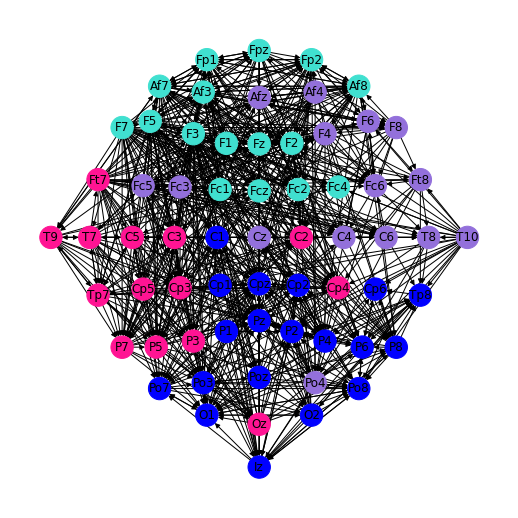

In [ ]:
plt.figure(1,figsize=(7,7))
nx.draw(g1, with_labels=True, pos=coords_tot, node_color=color_comm1, node_size=500)

In [ ]:
comm2_1 = leicht_new_comm2.communities[0]
comm2_2 = leicht_new_comm2.communities[1]
comm2_3 = leicht_new_comm2.communities[2]
comm2_4 = leicht_new_comm2.communities[3]


color_comm2 = []
for node in g2:
    if node in comm2_1:
      color_comm2.append('blue')
    elif node in comm2_2:
      color_comm2.append("turquoise")
    elif node in comm2_3:
      color_comm2.append("mediumpurple")
    elif node in comm2_4: 
      color_comm2.append("deeppink") 
    else:
      print(node) 

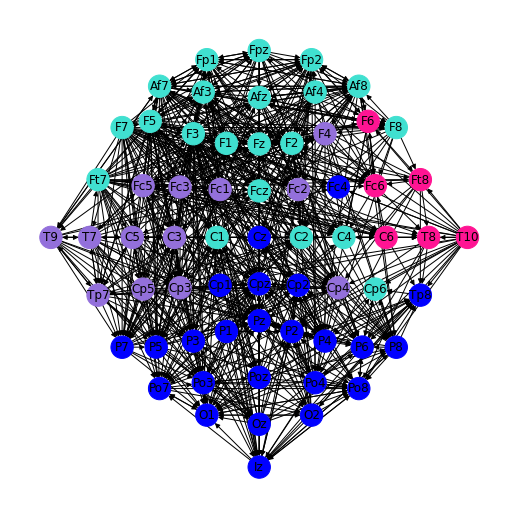

In [ ]:
plt.figure(1,figsize=(7,7))
nx.draw(g1, with_labels=True, pos=coords_tot, node_color=color_comm2, node_size=500)

## 4.3

In [ ]:
pip install infomap

In [ ]:
#diz to set graphs' labels back to numbers so that infomap can read them
names_ch = [s.replace('.', '') for s in ch_eo]
diz = {k:0 for k in names_ch}
for i in range(64):
  diz[names_ch[i]] = i

In [ ]:
#how to save a graph to later put on infomap online
#fh = open("test.edgelist2", "wb")
#nx.write_edgelist(g2_copy, fh, data=False, delimiter=" ")

In [ ]:
import infomap

def find_communities(G):
    #Partition network with the Infomap algorithm and annotates nodes with 'community' id.
    im = infomap.Infomap("--directed")
    print("Building Infomap network from a NetworkX graph...")
    for source, target in G.edges:
        im.add_link(source, target)

    im.run()
    print(f"Found {im.num_top_modules} modules with codelength: {im.codelength}")

    communities = im.get_modules()
    nx.set_node_attributes(G, communities, 'community')

### Eyes open

In [ ]:
g1_copy = g1.copy()
g1_copy =nx.relabel_nodes(g1_copy, diz)
find_communities(g1_copy)

Building Infomap network from a NetworkX graph...
Found 3 modules with codelength: 4.737067065572375


In [ ]:
communities1 = [c - 1 for c in nx.get_node_attributes(g1_copy, 'community').values()]
num_communities1 = max(communities1) + 1

In [ ]:
# color map from http://colorbrewer2.org/
cmap_light = colors.ListedColormap(['#a6cee3', '#b2df8a', '#fb9a99', '#fdbf6f', '#cab2d6'], 'indexed', num_communities)

### Eyes Closed

In [ ]:
g2_copy = g2.copy()
g2_copy =nx.relabel_nodes(g2_copy, diz)
find_communities(g2_copy)

Building Infomap network from a NetworkX graph...
Found 4 modules with codelength: 5.2917600946613135


In [ ]:
communities2 = [c - 1 for c in nx.get_node_attributes(g2_copy, 'community').values()]
num_communities2 = max(communities2) + 1

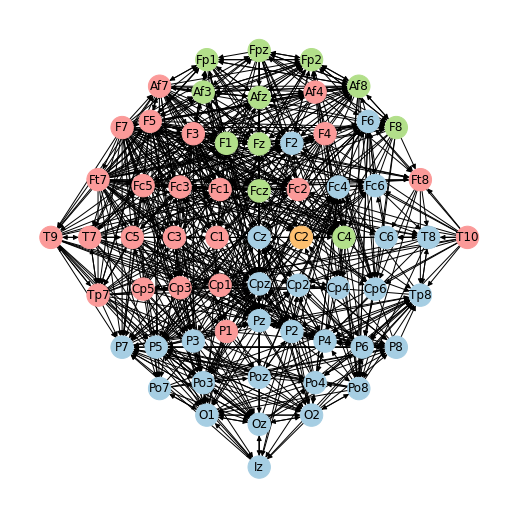

In [ ]:
plt.figure(1,figsize=(7,7))
g2_copy = nx.relabel_nodes(g2_copy, label_mapping_tot)
nx.draw(g2_copy, with_labels=True, pos=coords_tot, node_color=communities2, node_size=500, cmap=cmap_light)